### Monte Carlo Control Algorithm for GridWorld Problem

In [314]:
from enum import Enum
import random
import matplotlib.pyplot as plt
import numpy as np

#### Enviroment
Model represeting enviroment of Grid World, where agent need to find the best path to reward.

In [340]:
class Action(Enum):
    UP = 'UP'
    DOWN = "DOWN"
    LEFT = "LEFT"
    RIGHT = "RIGHT"
    
CONST_PENALTY = -0.1   

env = {
    ((0,0), Action.DOWN) : [(1., ((0,1), CONST_PENALTY))],
    ((0,0), Action.RIGHT) : [(1., ((1,0), CONST_PENALTY))],
    ((1,0), Action.LEFT) : [(1., ((0,0), CONST_PENALTY))],
    ((1,0), Action.RIGHT) : [(1., ((2,0), CONST_PENALTY))],
    ((2,0), Action.LEFT) : [(1., ((1,0), CONST_PENALTY))],
    ((2,0), Action.RIGHT) : [(.1, ((3,0), 1.)), (.9, ((1,0), CONST_PENALTY))],
    ((2,0), Action.DOWN) : [(1., ((2,1), CONST_PENALTY))],
    ((0,1), Action.DOWN) : [(1., ((0,2), CONST_PENALTY))],
    ((0,1), Action.UP) : [(1., ((0,0), CONST_PENALTY))],
    ((2,1), Action.UP) : [(.7, ((2,0), CONST_PENALTY)), (.3, ((3,1), -1.))],
    ((2,1), Action.DOWN) : [(1., ((2,1), CONST_PENALTY))],
    ((2,1), Action.RIGHT) : [(1., ((3,1), -1.))],
    ((0,2), Action.UP) : [(1., ((0,1), CONST_PENALTY))],
    ((0,2), Action.RIGHT) : [(1., ((1,2), CONST_PENALTY))],
    ((1,2), Action.RIGHT) : [(1., ((2,2), CONST_PENALTY))],
    ((1,2), Action.LEFT) : [(1., ((0,2), CONST_PENALTY))],
    ((2,2), Action.RIGHT) : [(1., ((3,2), CONST_PENALTY))],
    ((2,2), Action.LEFT) : [(1., ((1,2), CONST_PENALTY))],
    ((2,2), Action.UP) : [(1., ((2,1), CONST_PENALTY))],
    ((3,2), Action.LEFT) : [(1., ((2,2), CONST_PENALTY))],
    ((3,2), Action.UP) : [(1., ((3,1), -1.))],
}

actions = {
    (0,0) : {Action.DOWN, Action.RIGHT},
    (1,0) : {Action.LEFT, Action.RIGHT},
    (2,0) : {Action.LEFT, Action.RIGHT, Action.DOWN},
    (3,0) : {},
    (0,1) : {Action.UP, Action.DOWN},
    (2,1) : {Action.UP, Action.DOWN, Action.RIGHT},
    (3,1) : {},
    (0,2) : {Action.UP, Action.RIGHT},
    (1,2) : {Action.RIGHT, Action.LEFT},
    (2,2) : {Action.RIGHT, Action.LEFT, Action.UP},
    (3,2) : {Action.LEFT, Action.UP}
}

def env_return(state, action):
    probabilities, return_value = zip(*env[(state, action)])
    return random.choices(return_value, weights=probabilities, k=1)[0]  

#### Policy
Initiated as random allowed action for each state.

In [316]:
def get_random_policy():    
    policy = {}
    for state, allowed_actions in actions.items():
        if allowed_actions:
            policy[state] = random.choice(list(allowed_actions))
    return policy

In [317]:
def display_policy_on_board(policy):
    rows, cols = 3, 4
    grid = [[" " for _ in range(cols)] for _ in range(rows)]
    
    action_symbols = {
        Action.UP: "↑",
        Action.DOWN: "↓",
        Action.LEFT: "←",
        Action.RIGHT: "→"
    }

    for (x, y), action in policy.items():
        grid[y][x] = action_symbols[action]

    for row in grid:
        print(" | ".join(row))

#### Action value function
Represented by map. Includes current action value mean and current number of examples (examples number for updating mean)

In [318]:
def get_Q():    
    Q = {}
    for (state, action) in env:
        Q[(state, action)] = (0, 0)
    return Q
    

Plays episode base on given init state and action than follows the policy. Return history of states-actions and rewards for them.

In [319]:
def play_episode(policy, init_state, init_action, epsilon):
    states_actions = [(init_state, init_action)]
    next_state, reward = env_return(state=init_state, action=init_action)
    rewards = [reward]
    current_state = next_state
    while len(actions[current_state]) > 0:
        if(random.random() > epsilon):
            action = policy[current_state]
        else:
            action = random.choice(list(actions[current_state]))
        next_state, reward = env_return(state=current_state, action=action)
        states_actions.append((current_state, action))
        rewards.append(reward)
        current_state = next_state
    return (states_actions, rewards) 

Update policy base on current max mean from Action Value Function (Q) (for each state)

In [320]:
def update_policy(policy, Q):
    for state in policy:
        max_mean = float('-inf')
        max_action = None
        for action in actions[state]:
            mean_Q, _ = Q[(state, action)]
            if mean_Q > max_mean:
                max_mean = mean_Q
                max_action = action
        if max_action != None:
            policy[state] = max_action

Plays a few episodes and updates Action Value Function mean base on result. Then updating policy.

In [360]:
def train_agent(policy, Q, gamma=.1, epsilon=.1):
    rewards_history = []
    for _ in range(100):
        init_state, init_action = random.choice(list(env))
        states_actions, rewards = play_episode(
            policy=policy,
            init_state=init_state,
            init_action=init_action,
            epsilon=epsilon
        )
        G = 0
        for t in reversed(range(len(states_actions))):
            G = rewards[t] + gamma*G
            mean_Q, N_Q = Q[states_actions[t]]
            Q[states_actions[t]] = ((N_Q * mean_Q + G)/(N_Q + 1), N_Q + 1)
        update_policy(policy=policy, Q=Q)
        rewards_history.append(sum(rewards))
    return policy, Q, rewards_history

→ | → | → |  
↑ |   | ↓ |  
↑ | ← | ↑ | ←


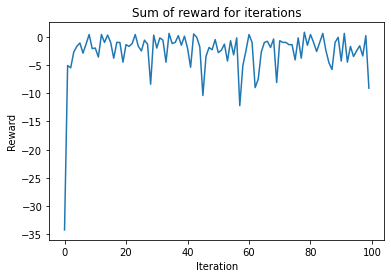

In [362]:
policy, Q, rewards_history = train_agent(policy=get_random_policy(), Q=get_Q(), epsilon=.1)
display_policy_on_board(policy)

plt.plot(rewards_history)

plt.title('Sum of reward for iterations')
plt.xlabel('Iteration')
plt.ylabel('Reward')

plt.show()


In [363]:
display(Q)

{((0, 0), <Action.DOWN: 'DOWN'>): (-0.1111000000007778, 10),
 ((0, 0), <Action.RIGHT: 'RIGHT'>): (-0.1106205197040946, 159),
 ((1, 0), <Action.LEFT: 'LEFT'>): (-0.11110142144330945, 117),
 ((1, 0), <Action.RIGHT: 'RIGHT'>): (-0.10259857708595349, 657),
 ((2, 0), <Action.LEFT: 'LEFT'>): (-0.11027975267489715, 27),
 ((2, 0), <Action.RIGHT: 'RIGHT'>): (-0.020579252476204263, 631),
 ((2, 0), <Action.DOWN: 'DOWN'>): (-0.11418363916667226, 32),
 ((0, 1), <Action.DOWN: 'DOWN'>): (-0.1111109865593494, 82),
 ((0, 1), <Action.UP: 'UP'>): (-0.11094824010780457, 41),
 ((2, 1), <Action.UP: 'UP'>): (-0.3771037002693602, 33),
 ((2, 1), <Action.DOWN: 'DOWN'>): (-0.11605475427439854, 694),
 ((2, 1), <Action.RIGHT: 'RIGHT'>): (-1.0, 32),
 ((0, 2), <Action.UP: 'UP'>): (-0.11110554531998654, 100),
 ((0, 2), <Action.RIGHT: 'RIGHT'>): (-0.11111208333333308, 8),
 ((1, 2), <Action.RIGHT: 'RIGHT'>): (-0.11210974834567893, 9),
 ((1, 2), <Action.LEFT: 'LEFT'>): (-0.11110962961480593, 15),
 ((2, 2), <Action.RIGHT